In [44]:
import torch
import torchvision  # la liberia tiene modelos preentrenados y datasets
import os
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
import random
from fastprogress import master_bar, progress_bar
import numpy as np
from sklearn.metrics import roc_auc_score
from albumentations import Compose, Flip, ToGray
from sklearn.preprocessing import OneHotEncoder

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.__version__ , DEVICE

('1.7.0', 'cuda')

In [2]:
PATH = "/kaggle/input"
os.listdir(PATH)

['dataset-melanoma224', 'melanoma224']

In [58]:
# Entrenamos nuestro encoder con todos los datos
train = pd.read_csv(f'{PATH}/melanoma224/train.csv')
train = train.fillna("unk")
train['age_approx'] = train['age_approx'].astype(str)
oh_encoder = OneHotEncoder()
cols = ["sex","age_approx","anatom_site_general_challenge"]
oh_encoder.fit(train[cols])
oh_encoder.categories_

[array(['female', 'male', 'unk'], dtype=object),
 array(['0.0', '10.0', '15.0', '20.0', '25.0', '30.0', '35.0', '40.0',
        '45.0', '50.0', '55.0', '60.0', '65.0', '70.0', '75.0', '80.0',
        '85.0', '90.0', 'unk'], dtype=object),
 array(['head/neck', 'lower extremity', 'oral/genital', 'palms/soles',
        'torso', 'unk', 'upper extremity'], dtype=object)]

## Cargamos todos los datos y ajustamos los Nan

In [59]:
#train = pd.read_csv(f'{PATH}/dataset-melanoma224/train_split.csv')
train = pd.read_csv(f'{PATH}/dataset-melanoma224/subset.csv')
val = pd.read_csv(f'{PATH}/dataset-melanoma224/val_split.csv')
train = train.fillna("unk")
val = val.fillna("unk")
train['age_approx'] = train['age_approx'].astype(str)
val['age_approx'] = val['age_approx'].astype(str)
train.shape, val.shape

((2220, 8), (10932, 8))

In [60]:
train["path"] = [f'{PATH}/melanoma224/jpeg224/train/{img}.jpg' for img in train["image_name"]]
val["path"] = [f'{PATH}/melanoma224/jpeg224/train/{img}.jpg' for img in val["image_name"]]

In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2220 entries, 0 to 2219
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   image_name                     2220 non-null   object
 1   patient_id                     2220 non-null   object
 2   sex                            2220 non-null   object
 3   age_approx                     2220 non-null   object
 4   anatom_site_general_challenge  2220 non-null   object
 5   diagnosis                      2220 non-null   object
 6   benign_malignant               2220 non-null   object
 7   target                         2220 non-null   int64 
 8   path                           2220 non-null   object
dtypes: int64(1), object(8)
memory usage: 156.2+ KB


In [62]:
class Dataset(torch.utils.data.Dataset): # Deberemos crear una clase datasets que heredara las propiedades de torch.utils.data.Dataset, tres funciones obligatorias, init, len, getitem
    
    def __init__(self, images, meta, labels=None,  train = True, cache=False, trans=None): # Constructor de esta clase, parametos que tenemos que pasarle para iniciarlo (images, labels)
        self.cache = cache
        self.images = [self.load_img(img) for img in images] if cache else images
        meta = oh_encoder.transform(meta).toarray() # incorporamos los metadatos realizandole el encoding
        self.meta = torch.tensor(meta).float() # hay que transformarlos en tensores para meterlo en la red neuronal
        self.train = train
        self.trans = trans
        if train:
            self.labels = [torch.tensor([lab]).float() for lab in labels]
    
    def __len__(self): # Nos devolvera la longitud
        return len(self.images)
    
    def load_img(self, img):
        return io.imread(img) # leera los pixeles de la imagen
    
    def __getitem__(self,ix): # Funcions que se llamará para extraer un item de nuestro datasets
        img = self.images[ix] if self.cache else self.load_img(self.images[ix])
        if self.trans:
            img = self.trans(image=img)['image']
        if self.train:
            return torch.from_numpy(img), self.meta[ix], self.labels[ix] # transformamos el numpy en un tensor de pytorch y nos lo devolverá con la etiqueta
        return torch.from_numpy(img),self.meta[ix]
    
trans = Compose([ # instaciamos el compose para añadir las transformaciones
    Flip(),
    ToGray()
])

In [63]:
cols = ["sex","age_approx","anatom_site_general_challenge"]
dataset = {
    "train": Dataset(train["path"],train[cols], train["target"], cache=True, trans=trans),
    "val": Dataset(val["path"],train[cols], val["target"], cache=True,trans=trans)
}

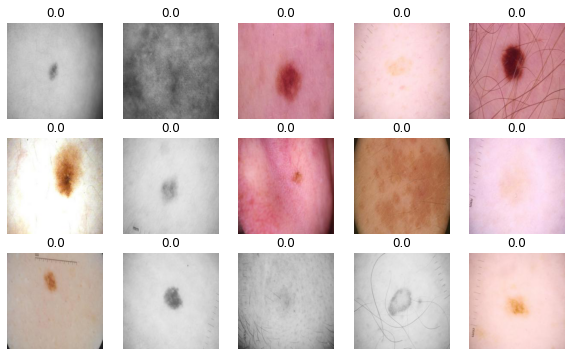

In [66]:
r, c = 3,5
fig = plt.figure(figsize=(2*c,2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r,c,_r*c+_c+1)
        ix = random.randint(0, len(dataset["train"])-1)
        img, meta, label = dataset["train"][ix]
        plt.imshow(img)
        plt.title(label.item()) # Si ponemos item() nos devolvera el numero y no un tensor
        plt.axis(False)
plt.show()       

In [74]:
class Net(torch.nn.Module): # Crearemos nuestra clase de red neuronal y deberemos llamar a la instancia de torch.nn.Module . Minimo dos funciones, (init y forward)
    
    def __init__(self,num_inputs=29):
        super().__init__()
        
        # IMAGE ENCODER
        resnet = torchvision.models.resnet50(pretrained=True) # nos devolvera una dimension de 1000 porque la resnet50 esta entrenada en 1000 clases
        #freeze
        for param in resnet.parameters():
            param.requires_grad = False #Cuando se aplique el algoritmo de backpropagation no aplicara los gradientes, no entrenará las primeras capas
        self.encoder = torch.nn.Sequential(*list(resnet.children())[:-1]) # Le decimos al pytorch que coja todas las capas menos la ultima ya que es una layer lineal que crearemos nosotros despues
        
        #METADATA
        self.metaencoder = torch.nn.Sequential(
            torch.nn.Linear(num_inputs, 100),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(100, 3),
            torch.nn.ReLU(inplace=True)
        )
        
        # SELF.HEAD      CAPA QUE CONCATENARA LAS DOS SALIDAS
        self.head = torch.nn.Linear(2048+3,1) # Capa lineal que cogera los 2048 que viene de las imagenes y 3 que vienen de los metadatos para que nos devuelva solo 1 valor 
    
    def forward(self, x, y): # Funcion encargada de aplicar todas las capas
        # IMAGEN
        B, H, W, C = x.shape # Sacamos todas las dimensiones de nuestro tensor
        x = (x/255.).float().view(B,C,H,W) # La funcion view nos permite cambiar el orden de las dimensiones de nuestro tensor
        x = self.encoder(x) # Nos devuelve un tensor [2048,1,1] hay que cambiarlo para que coincida con la capa self.head
        x = x.view(B,-1) # la dimension del batch la mantiene pero los (2048,1,1) la aplana
        
        # METADATA
        y = self.metaencoder(y)
        
        # CONCATENAR
        z = torch.cat([x,y],1) #Si ponemos cero lo concatenamos al batch pero queremos a la otra dimension 2048+3
        z = self.head(z) # Se lo pasamos al head
        return z
        
        
    

In [75]:
# Ejemplo random  para probar que funciona
model = Net() # Instanciamos la red neuronal

BATCH_SIZE = 64
# model le pasaremos un batch de imagenes 
output = model(torch.randn(BATCH_SIZE, 224,224,3), torch.randn(64,29)) # le pasamos un tensor aleatorio para probar su funcionamiento y ver que nos devuelve lo mismo 
output.shape

# la dimension de los canales (nuestro caso 3) tiene que ir la segunda

torch.Size([64, 1])

In [76]:
BATCH_SIZE = 64

dataloader = { # El objeto DataLoader nos permite iterar por todo el dataset y cargar los datos en el model en batches
    "train": torch.utils.data.DataLoader(dataset['train'], batch_size = BATCH_SIZE, shuffle=True),
    "val": torch.utils.data.DataLoader(dataset['val'], batch_size = BATCH_SIZE)
}

In [77]:
imgs, meta, labels = next(iter(dataloader['train']))

imgs.shape, meta.shape, labels.shape

(torch.Size([64, 224, 224, 3]), torch.Size([64, 29]), torch.Size([64, 1]))

In [78]:
# Definimos nuestro funcion para evaluar nuestro modelo
def AUC(outputs, labels):
    outputs = torch.sigmoid(outputs)
    outputs = outputs.numpy() # Pasamos de tensores a numpy por que la función roc_auc_score trabaja 
    labels = labels.numpy()
    auc = roc_auc_score(labels, outputs)
    return auc

In [79]:
# INSTANCIAMOS NUESTRO MODELO Y PARAMETROS

net = Net() # Instanciamos la red neuronal
net.to(DEVICE) # Enviamos nuestra red neuronal a la gpu

optimizer = torch.optim.Adam(net.parameters()) # Optimizador
criterion = torch.nn.BCEWithLogitsLoss() # Funcion de perdida


In [80]:
# ENTRENAMIENTO

EPOCHS = 10
validation_steps = 10
mb = master_bar(range(1, EPOCHS+1)) # Para mostrar el progreso
best_auc = 0 

# LOOP 
for epoch in mb: # Para entrenar nuestro modelo deberemos pasarlo nº epochs por todo nuestro dataset o (DataLoader: datasets en batches)
    train_loss = []
    net.train()# Ponemos a la red neuronal en modo entrenamiento
    
    #TRAIN MODEL
    for batch in progress_bar(dataloader["train"], parent=mb): # realizamos un for por nuestro dataloader ademas de añadir el progress_bar para ver el progreso indicando su padre 
        imgs, meta, labels = batch
        imgs, meta, labels = imgs.to(DEVICE), meta.to(DEVICE), labels.to(DEVICE) # Enviamos las imagenes y etiquetas a la gpu
        outputs = net(imgs,meta) # Le pasamos nuestras imagenes y metadatos a la red neuronal
        optimizer.zero_grad()# Pondrá a cero los gradientes, Si no lo ponemos ira acumulando los gradientes cada llamada a backward
        loss = criterion(outputs, labels) # al optimizador le pasamos los outputs y las etiquetas y nos devolvera la loss function
        loss.backward() # Backward calculara todos los gradientes de esta loss functions con respecto a los pesos de la red
        optimizer.step()# Aplicará los gradientes
        train_loss.append(loss.item())
        mb.child.comment = f' loss: {np.mean(train_loss):.5}'
        
    # VALIDACION
    val_loss = []
    net.eval() # Ponemos la red neuronal en modo evaluación 
    validation_step = 0
    val_outputs = torch.tensor([])# Iremos guardando todos los outputs y targets para la validacion de la métrica AUC
    val_targets = torch.tensor([])
    with torch.no_grad(): # No calculará gradientes porque solo estamos validando
        for batch in progress_bar(dataloader["val"], parent=mb): 
            imgs, meta, labels = batch
            imgs, meta, labels = imgs.to(DEVICE), meta.to(DEVICE), labels.to(DEVICE) 
            outputs = net(imgs, meta)
            loss = criterion(outputs, labels) 
            optimizer.step()
            val_loss.append(loss.item())
            mb.child.comment = f' val_loss: {np.mean(val_loss):.5}'
            val_outputs = torch.cat([val_outputs,outputs.cpu()])
            val_targets = torch.cat([val_targets, labels.cpu()])
            validation_step += 1 
            if validation_step > validation_steps:
                break
    
    auc = AUC(val_outputs, val_targets)
    if auc > best_auc:
        best_auc = auc
        torch.save(net, "model.pth")
        print(f"Best model! {best_auc:.5}")
    mb.write(f'Epoch {epoch}/{EPOCHS}   train_loss: {np.mean(train_loss):.5}   val_loss: {np.mean(val_loss):.5}  val_auc: {auc:.5}')
        

Best model! 0.63832
Best model! 0.70311
Best model! 0.73769
Best model! 0.77251
Best model! 0.84702
Best model! 0.85293


## Cargamos los datos de test y realizamos predicciones


In [84]:
test = pd.read_csv(f'{PATH}/melanoma224/test.csv')
test["path"] = [f'{PATH}/melanoma224/jpeg224/test/{img}.jpg' for img in test["image_name"]]
test = test.fillna("unk")
test['age_approx'] = test['age_approx'].astype(str)
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,path
0,ISIC_0052060,IP_3579794,male,70.0,unk,/kaggle/input/melanoma224/jpeg224/test/ISIC_00...
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,/kaggle/input/melanoma224/jpeg224/test/ISIC_00...
2,ISIC_0058510,IP_7960270,female,55.0,torso,/kaggle/input/melanoma224/jpeg224/test/ISIC_00...
3,ISIC_0073313,IP_6375035,female,50.0,torso,/kaggle/input/melanoma224/jpeg224/test/ISIC_00...
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,/kaggle/input/melanoma224/jpeg224/test/ISIC_00...


In [85]:
cols = ["sex","age_approx","anatom_site_general_challenge"]
test_dataset = Dataset(test["path"], test[cols], train = False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 200)

In [86]:
imgs, meta = next(iter(test_loader))
imgs.shape, meta.shape

(torch.Size([200, 224, 224, 3]), torch.Size([200, 29]))

In [87]:
model = torch.load("model.pth")
model.to(DEVICE)
model.eval()
preds = torch.tensor([]).to(DEVICE)
with torch.no_grad():
        for imgs, meta in progress_bar(test_loader): 
            imgs, meta = imgs.to(DEVICE), meta.to(DEVICE)
            outputs = model(imgs, meta)
            outputs = torch.sigmoid(outputs)
            preds = torch.cat([preds, outputs.view(-1)]) # view nos permitiria estirar todos los datos

In [88]:
preds

tensor([0.0050, 0.0008, 0.0014,  ..., 0.0038, 0.0032, 0.0260], device='cuda:0')

In [89]:
submission = pd.DataFrame({'image_name':test["image_name"].values,"target":preds.cpu().numpy()})
submission

,image_name,target
0,ISIC_0052060,0.005010
1,ISIC_0052349,0.000814
2,ISIC_0058510,0.001380
3,ISIC_0073313,0.001045
4,ISIC_0073502,0.063791
...,...,...
10977,ISIC_9992485,0.005894
10978,ISIC_9996992,0.003391
10979,ISIC_9997917,0.003758
10980,ISIC_9998234,0.003198


In [90]:
submission.to_csv("submission.csv", index=False)